### 2: Trend Removal
Convolution of Gaussian kernel to removal trend from data.

In [1]:
# Import Packages/Libraries
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python 
import pandas as pd
import seaborn as sns
import numpy as np                        # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
import astropy.convolution.convolve as convolve
import scipy.signal as signal             # kernel for moving window calculation
import math                               # trig etc.

In [2]:
df = pd.read_csv('df_clean.csv')

### Removal of Porosity Trend

There are 217 data with:
   mean of      0.13536741338554403 
   min and max  0.0606929054762965 and 0.20438817014234475
   standard dev 0.024034484994892254 
We have made a kernel of size, number of grid cells (ny, nx) (41, 41)


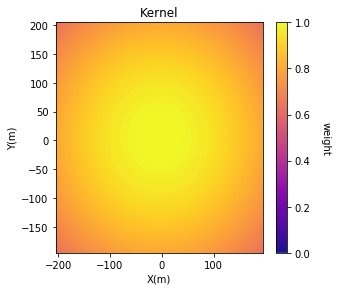

In [3]:
# decluster data
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',
                                          iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['PorWts'] = wts                            # add weights to the sample data DataFrame

# sparse porosity matrix
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.plasma # plotting parameters
por_grid = GSLIB.DataFrame2ndarray(df,'X','Y','Porosity',xmin, xmax, ymin, ymax, step=10.0)

# gaussian kernel trend
cmap = plt.cm.plasma
kernel_size = 41
gaus_std = 30
gkern1d = signal.gaussian(kernel_size,gaus_std).reshape(kernel_size, 1)
gkern2d = np.outer(gkern1d, gkern1d)
print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))

csize = 10.0
plt.subplot(111)
GSLIB.pixelplt_st(gkern2d,xmin=(-1 * kernel_size/2 * 10),xmax=(kernel_size/2 * 10),
                  ymin=(-1 * kernel_size/2 * 10),ymax=(kernel_size/2 * 10),
                  step=csize,vmin=0,vmax=1,
                  title='Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

porosity_trend = convolve(por_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

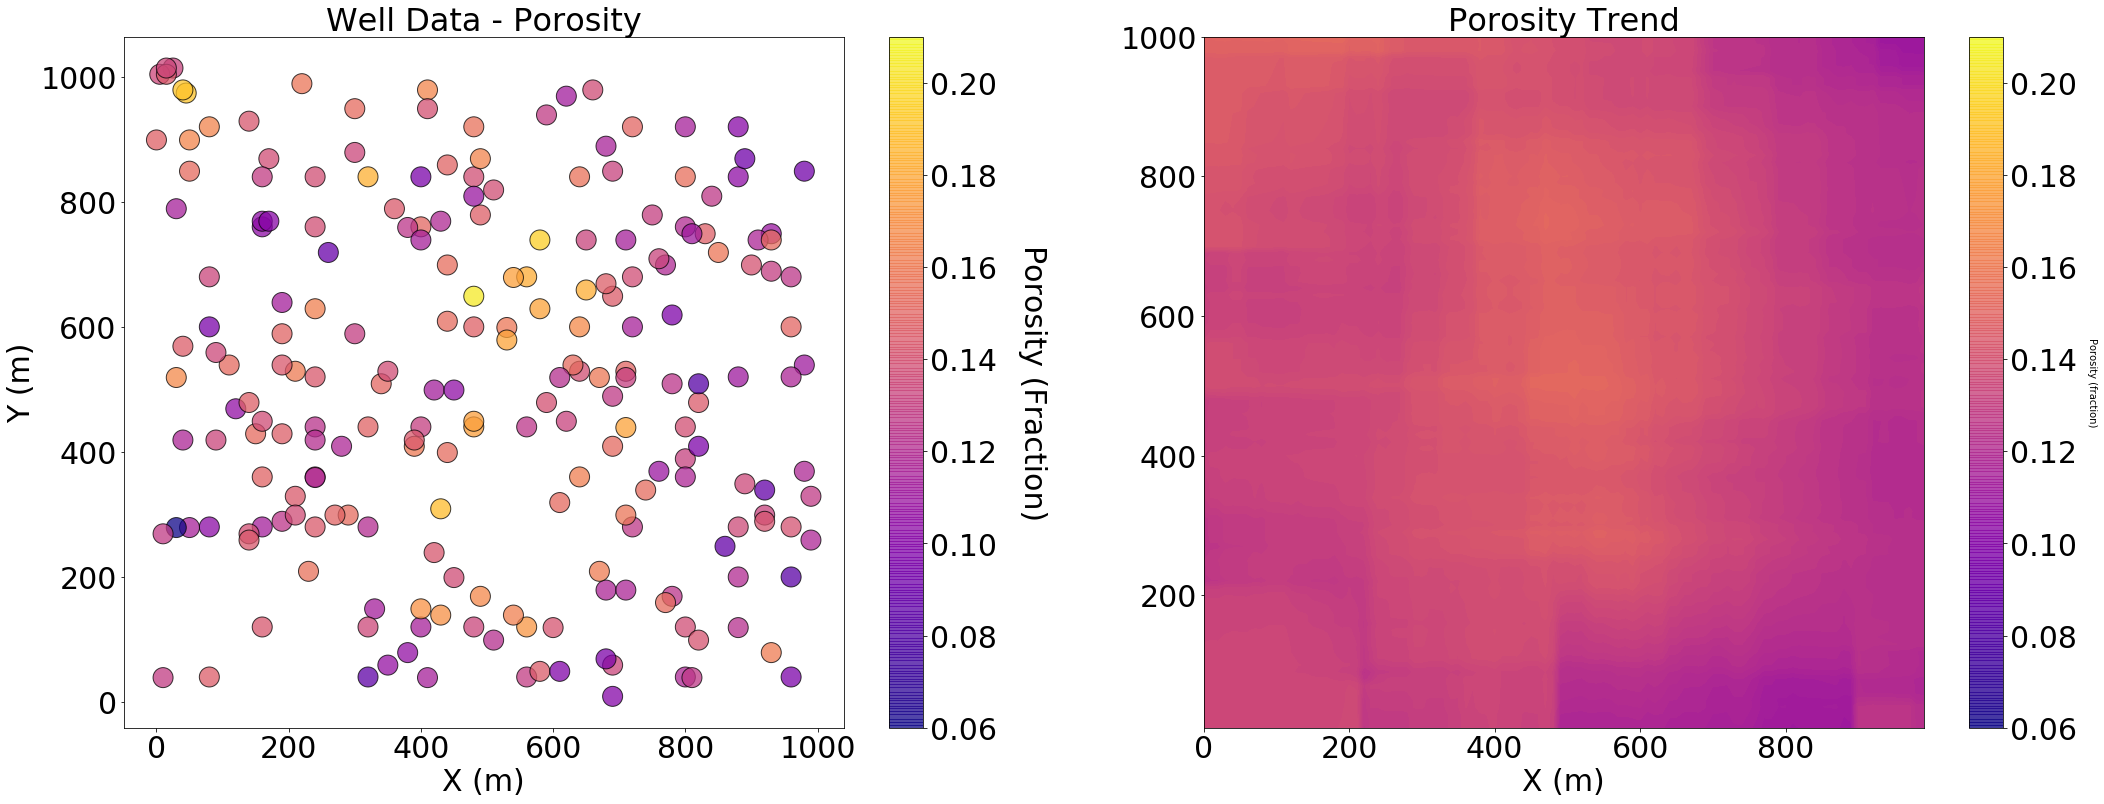

In [4]:
# visualizing data and trend in porosity
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)

plt.figure(figsize=(10,8))
pormin = 0.06; pormax = 0.21
plt.subplot(121)
plt.scatter(df['X'],df['Y'],s=400,c=df['Porosity'],
           marker=None,cmap=plt.cm.plasma,norm=None,vmin=pormin,
           vmax=pormax,alpha=0.75,verts=None,edgecolors="black")
cbar = plt.colorbar(orientation = 'vertical')
cbar.set_label('Porosity (Fraction)',rotation=270,labelpad=50,size=30)
ax = plt.gca()
ax.set_ylabel('Y (m)',fontsize=30)
ax.set_title('Well Data - Porosity',fontsize=32)
ax.set_xlabel('X (m)',fontsize=30)

plt.subplot(122)
GSLIB.pixelplt_st(porosity_trend,xmin,xmax,ymin,ymax,csize,pormin,pormax,
                  'Porosity Trend','X(m)','Y(m)','Porosity (fraction)',cmap)
ax = plt.gca()
ax.set_ylabel('')
ax.set_title('Porosity Trend',fontsize=32)
ax.set_xlabel('X (m)',fontsize=30)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.75, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [5]:
# check portion of variance modeled by trend
def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

wavg_por,wstd_por = weighted_avg_and_std(df['Porosity'],df['PorWts']) 

wavg_por_trend = np.average(porosity_trend)
wstd_por_trend = np.std(porosity_trend)

print('Declustered Porosity Data: Average ' + str(round(wavg_por,4)) + ', Var ' + str(round(wstd_por**2,5)))
print('Porosity Trend: Average            ' + str(round(wavg_por_trend,4)) + ', Var ' + str(round(wstd_por_trend**2,5)))
print('Proportion Trend / Known:          ' + str(round(wstd_por_trend**2/(wstd_por**2),3)))
print('Proportion Residual / Unknown:     ' + str(round((wstd_por**2 - wstd_por_trend**2)/(wstd_por**2),3)))

Declustered Porosity Data: Average 0.132, Var 0.00058
Porosity Trend: Average            0.1348, Var 7e-05
Proportion Trend / Known:          0.12
Proportion Residual / Unknown:     0.88


To be conservative, only 12% of the total variance is being accounted for by the trend modeling. We think this is appropriate as the overall trend is not obvious to the eye, and therefore must be quite subtle

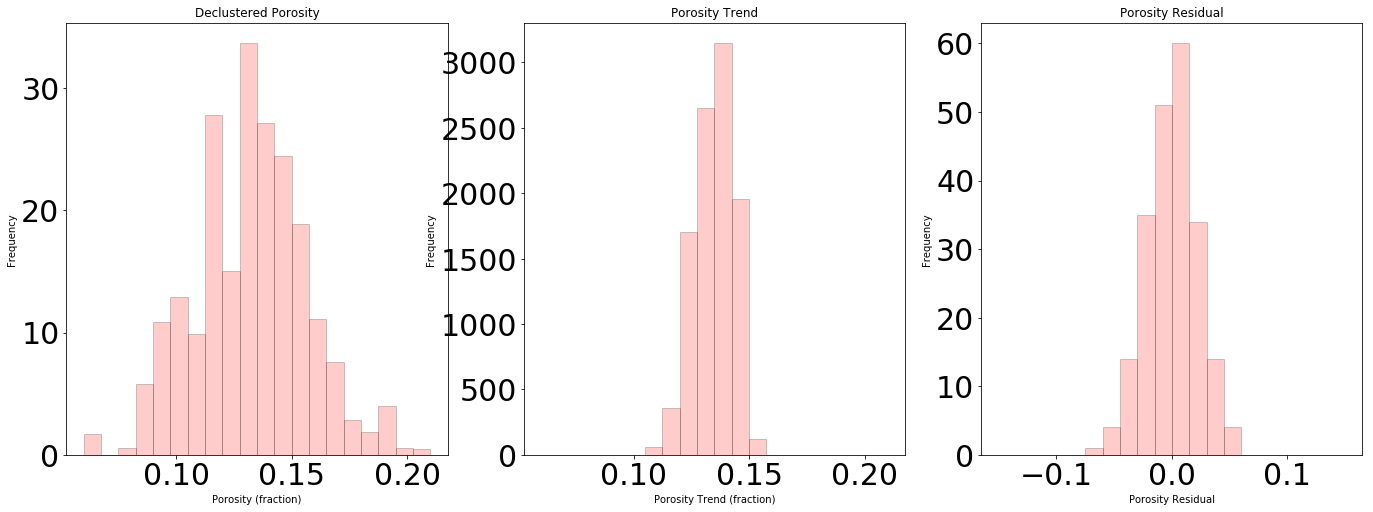

In [6]:
# add trend to dataframe -- removing trend from data
df = GSLIB.sample(porosity_trend,xmin,ymin,csize,"Por_Trend",df,'X','Y')
df['Por_Res'] = df['Porosity'] - df['Por_Trend'] # calculate the residual and add to DataFrame

# check histogram to trend
plt.subplot(131)
GSLIB.hist_st(df['Porosity'],pormin,pormax,False,False,20,
              df['PorWts'],'Porosity (fraction)','Declustered Porosity')

plt.subplot(132)
GSLIB.hist_st(porosity_trend.flatten(),pormin,pormax,False,False,20,None,
              'Porosity Trend (fraction)','Porosity Trend')

plt.subplot(133)
GSLIB.hist_st(df['Por_Res'],-(pormax-pormin),(pormax-pormin),False,False,20,None,
             'Porosity Residual','Porosity Residual')

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

### Removal of Permeability Trend

There are 217 data with:
   mean of      18.035989259779384 
   min and max  0.01805446870059259 and 193.74682353970672
   standard dev 31.507725592529994 
We have made a kernel of size, number of grid cells (ny, nx) (51, 51)


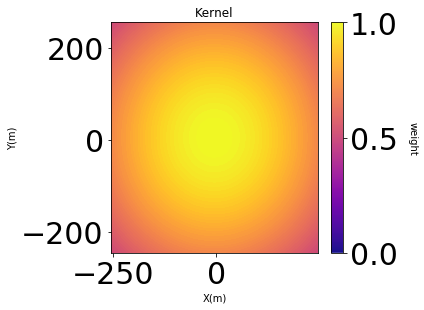

In [7]:
# decluster data
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Perm',
                                          iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['PermWts'] = wts                            # add weights to the sample data DataFrame

# sparse permeability matrix
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.plasma # plotting parameters
perm_grid = GSLIB.DataFrame2ndarray(df,'X','Y','Perm',xmin, xmax, ymin, ymax, step=10.0)

# gaussian kernel trend
cmap = plt.cm.plasma
kernel_size = 51
gaus_std = 30
gkern1d = signal.gaussian(kernel_size,gaus_std).reshape(kernel_size, 1)
gkern2d = np.outer(gkern1d, gkern1d)
print('We have made a kernel of size, number of grid cells (ny, nx) ' + str(gkern2d.shape))

csize = 10.0
plt.subplot(111)
GSLIB.pixelplt_st(gkern2d,xmin=(-1 * kernel_size/2 * 10),xmax=(kernel_size/2 * 10),
                  ymin=(-1 * kernel_size/2 * 10),ymax=(kernel_size/2 * 10),
                  step=csize,vmin=0,vmax=1,
                  title='Kernel',xlabel='X(m)',ylabel='Y(m)',vlabel='weight',cmap=cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.6, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

perm_trend = convolve(perm_grid,gkern2d,boundary='extend',nan_treatment='interpolate',normalize_kernel=True)

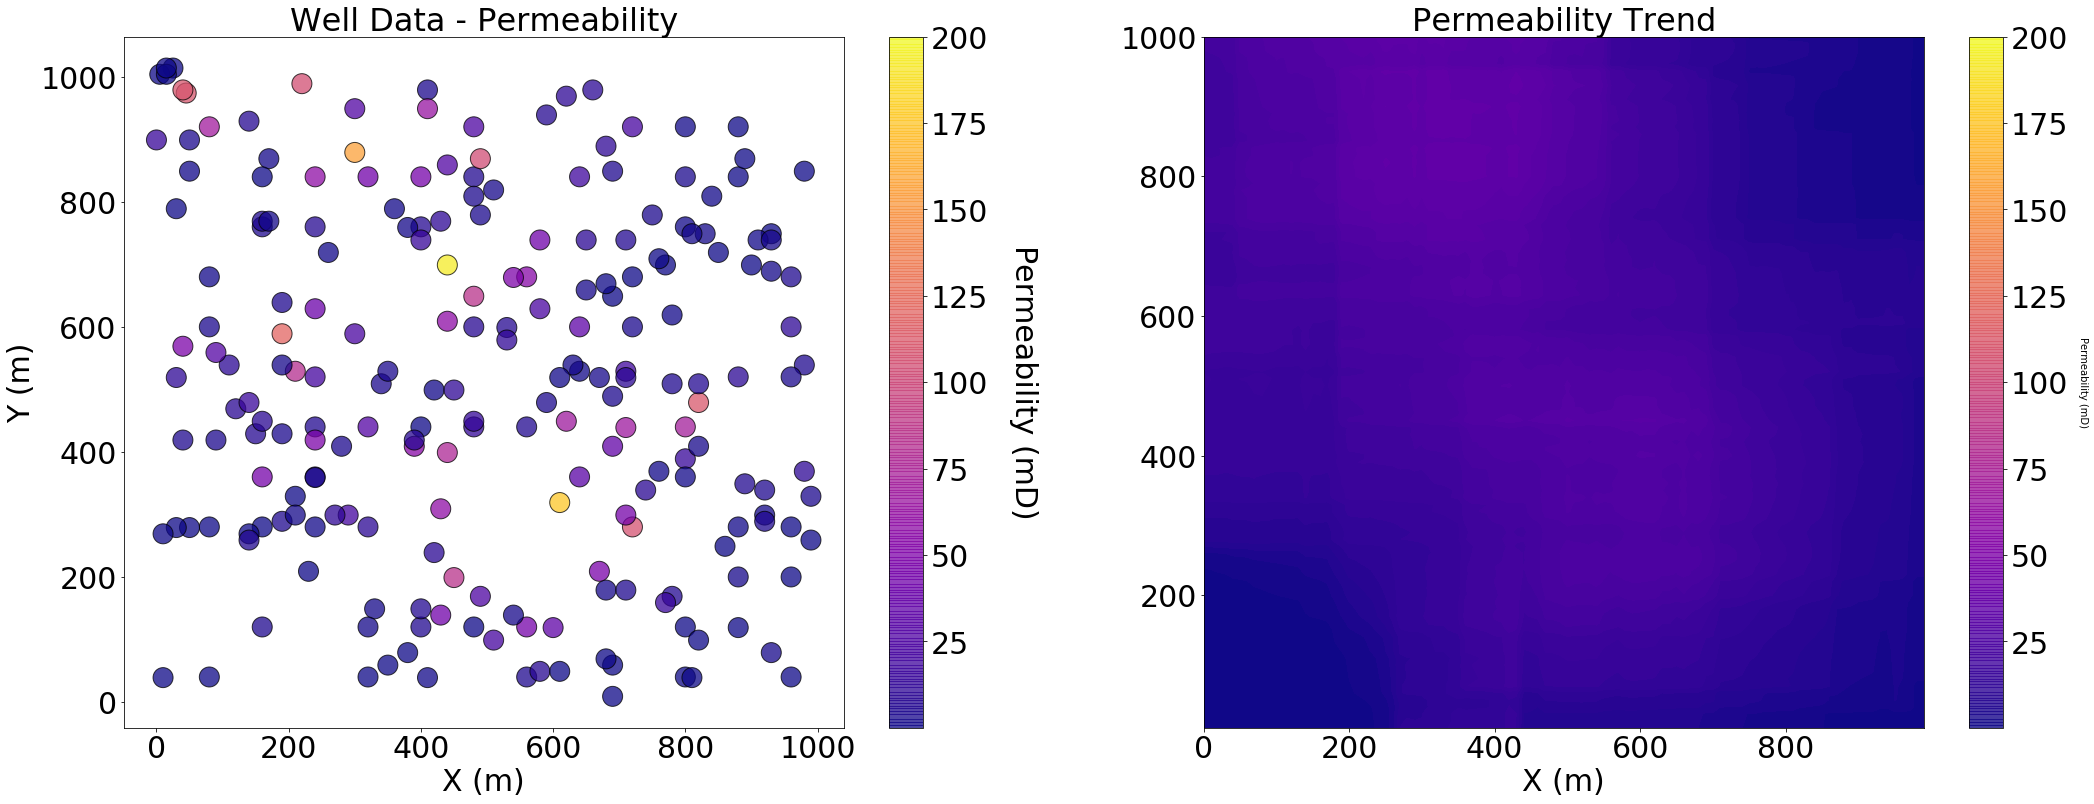

In [8]:
# visualizing data and trend in permeability
plt.rc('xtick',labelsize=30)
plt.rc('ytick',labelsize=30)

plt.figure(figsize=(10,8))
permin = 0.01; permax = 200.00
plt.subplot(121)
plt.scatter(df['X'],df['Y'],s=400,c=df['Perm'],
           marker=None,cmap=plt.cm.plasma,norm=None,vmin=permin,
           vmax=permax,alpha=0.75,verts=None,edgecolors="black")
cbar = plt.colorbar(orientation = 'vertical')
cbar.set_label('Permeability (mD)',rotation=270,labelpad=50,size=30)
ax = plt.gca()
ax.set_ylabel('Y (m)',fontsize=30)
ax.set_title('Well Data - Permeability',fontsize=32)
ax.set_xlabel('X (m)',fontsize=30)

plt.subplot(122)
GSLIB.pixelplt_st(perm_trend,xmin,xmax,ymin,ymax,csize,permin,permax,
                  'Permeability Trend','X(m)','Y(m)','Permeability (mD)',cmap)
ax = plt.gca()
ax.set_ylabel('')
ax.set_title('Permeability Trend',fontsize=32)
ax.set_xlabel('X (m)',fontsize=30)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.75, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

In [9]:
# check portion of variance modeled by trend
def weighted_avg_and_std(values, weights):                  # from Eric O Lebigot, stack overflow
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)
    return (average, math.sqrt(variance))

wavg_perm,wstd_perm = weighted_avg_and_std(df['Perm'],df['PermWts']) 

wavg_perm_trend = np.average(perm_trend)
wstd_perm_trend = np.std(perm_trend)

print('Declustered Permeability Data: Average ' + str(round(wavg_perm,4)) + ', Var ' + str(round(wstd_perm**2,5)))
print('Permeability Trend: Average            ' + str(round(wavg_perm_trend,4)) + ', Var ' + str(round(wstd_perm_trend**2,5)))
print('Proportion Trend / Known:          ' + str(round(wstd_perm_trend**2/(wstd_perm**2),3)))
print('Proportion Residual / Unknown:     ' + str(round((wstd_perm**2 - wstd_perm_trend**2)/(wstd_perm**2),3)))

Declustered Permeability Data: Average 14.2692, Var 819.41032
Permeability Trend: Average            16.9449, Var 83.09504
Proportion Trend / Known:          0.101
Proportion Residual / Unknown:     0.899


/home/jayh/anaconda2/envs/geo/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/home/jayh/anaconda2/envs/geo/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/jayh/anaconda2/envs/geo/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


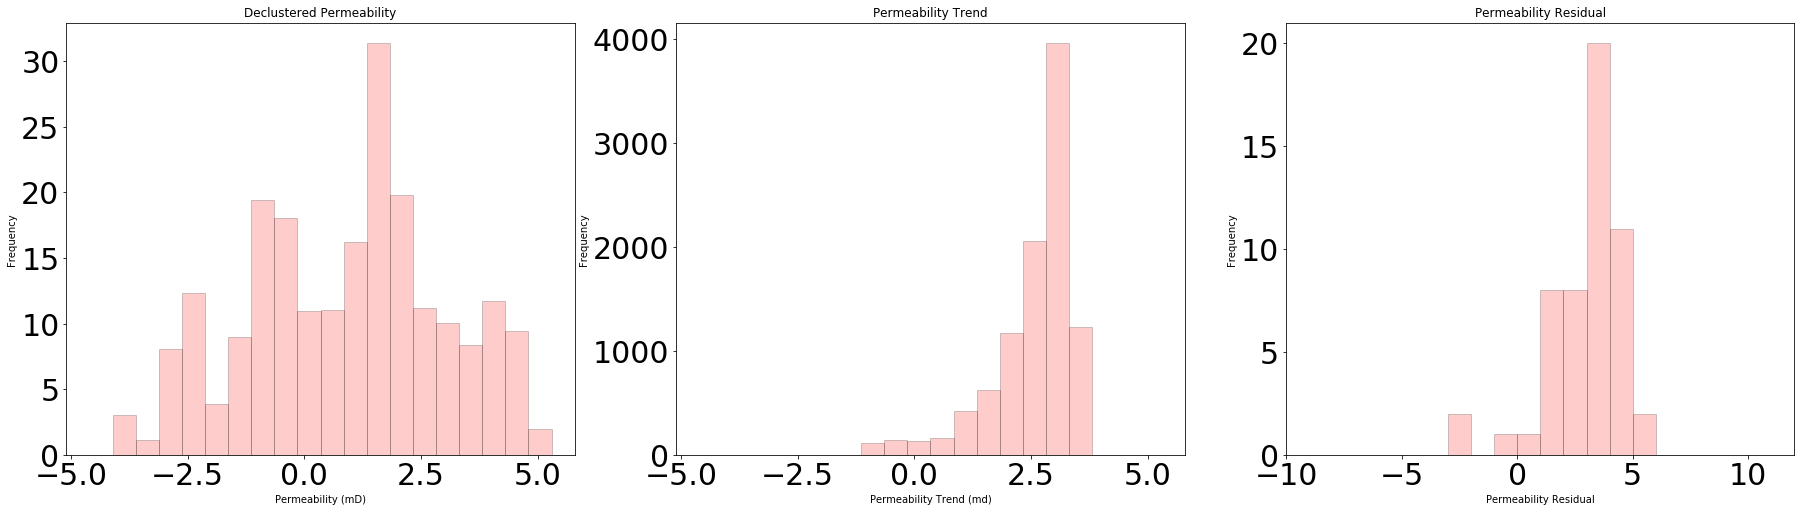

In [10]:
# add trend to dataframe -- removing trend from data
df = GSLIB.sample(perm_trend,xmin,ymin,csize,"Perm_Trend",df,'X','Y')
df['Perm_Res'] = df['Perm'] - df['Perm_Trend'] # calculate the residual and add to DataFrame

# check histogram to trend
plt.subplot(131)
GSLIB.hist_st(np.log(df['Perm']),np.log(permin),np.log(permax),False,False,20,
              df['PermWts'],'Permeability (mD)','Declustered Permeability')

plt.subplot(132)
GSLIB.hist_st(np.log(perm_trend.flatten()),np.log(permin),np.log(permax),False,False,20,None,
              'Permeability Trend (md)','Permeability Trend')

plt.subplot(133)
GSLIB.hist_st(np.log(df['Perm_Res']),-9.0,11.0,False,False,20,None,
             'Permeability Residual','Permeability Residual')

plt.subplots_adjust(left=0.0, bottom=0.0, right=4.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

See about 10% of variance explained by the trend. Permeability raw data, trend and residual presented above in log_10 space so we expect the distributions to center about 1. Residual doesn't look great, but looks like it is pseudo-normal about 1 which is what we want to see.

In [11]:
del df['Unnamed: 0']

In [12]:
df.head()

,X,Y,Facies,Porosity,Perm,AI,PorWts,Por_Trend,Por_Res,PermWts,Perm_Trend,Perm_Res
0,80.0,920.0,1.0,0.164331,69.106615,5012.616594,1.309515,0.144914,0.019417,1.449032,24.505396,44.601219
1,80.0,680.0,1.0,0.133723,1.558072,5710.579850,0.920515,0.132962,0.000761,0.965570,21.451624,-19.893552
2,80.0,600.0,1.0,0.096295,3.568959,4912.388066,0.895786,0.132065,-0.035770,0.928452,19.930179,-16.361219
3,80.0,40.0,1.0,0.145738,0.109943,6492.944055,5.103406,0.135363,0.010375,5.410643,0.527828,-0.417885
4,160.0,360.0,1.0,0.148611,45.082381,6643.024955,0.664773,0.134456,0.014155,0.825989,14.021498,31.060883


In [13]:
# save the detrended clean data
df.to_csv('df_detrended.csv')

In [14]:
# save trends
np.save('porositytrend.npy',porosity_trend)
np.save('permeabilitytrend.npy',perm_trend)